Loading training data...


Processing train data...
Loading test data...


Processing test data...


Initializing model layers...


Performing warmup...

Starting training...
Epoch 1, Batch 10/1563, Loss: 1.4636, Accuracy: 31.25%, Speed: 2.05 batches/sec
Epoch 1, Batch 20/1563, Loss: 1.4503, Accuracy: 43.75%, Speed: 5.45 batches/sec
Epoch 1, Batch 30/1563, Loss: 1.4371, Accuracy: 56.25%, Speed: 4.69 batches/sec
Epoch 1, Batch 40/1563, Loss: 1.4539, Accuracy: 37.5%, Speed: 5.15 batches/sec
Epoch 1, Batch 50/1563, Loss: 1.4304, Accuracy: 62.5%, Speed: 5.64 batches/sec
Epoch 1, Batch 60/1563, Loss: 1.4372, Accuracy: 56.25%, Speed: 5.25 batches/sec
Epoch 1, Batch 70/1563, Loss: 1.4554, Accuracy: 37.5%, Speed: 5.54 batches/sec
Epoch 1, Batch 80/1563, Loss: 1.4475, Accuracy: 43.75%, Speed: 5.09 batches/sec
Epoch 1, Batch 90/1563, Loss: 1.4253, Accuracy: 62.5%, Speed: 5.79 batches/sec
Epoch 1, Batch 100/1563, Loss: 1.4403, Accuracy: 50.0%, Speed: 5.08 batches/sec
Epoch 1, Batch 110/1563, Loss: 1.439, Accuracy: 50.0%, Speed: 5.25 batches/sec
Epoch 1, Batch 120/1563, Loss: 1.4458, Accuracy: 43.75%, Speed: 4.96 batches/sec
E

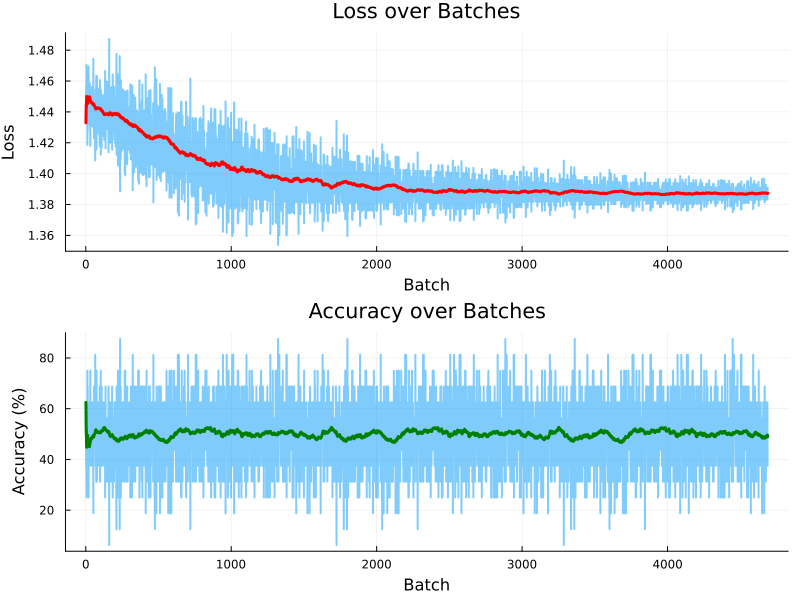

In [ ]:
using Statistics
using Random  # Dodajemy import Random dla funkcji shuffle i randperm

# Ustaw flagi optymalizacji
Base.Experimental.@optlevel 3
Base.Experimental.@inbounds true

# Include necessary modules
include("ConvModule.jl")
include("PoolModule.jl")
include("GlobalPoolModule.jl")
include("DenseModule.jl")
include("EmbeddingModule.jl")
include("IMDbDataLoader.jl")
include("LossAndAccuracy.jl")
include("NetworkHandlers.jl")
include("BatchNormModule.jl")

using .ConvModule, .PoolModule, .GlobalPoolModule, .IMDbDataLoader, .DenseModule, .EmbeddingModule, .BatchNormModule

println("Loading training data...")
train_features, train_labels = IMDbDataLoader.load_data(:train)
train_x, train_y = IMDbDataLoader.preprocess_data(train_features, train_labels; one_hot=true)
train_features = nothing  # Free memory
GC.gc()  # Force garbage collection

println("Loading test data...")
test_features, test_labels = IMDbDataLoader.load_data(:test)
test_x, test_y = IMDbDataLoader.preprocess_data(test_features, test_labels; one_hot=true)
test_features = nothing  # Free memory
GC.gc()  # Force garbage collection

# Create batches with optimal batch size for performance
batch_size = 16
train_data = IMDbDataLoader.batch_data((train_x, train_y), batch_size; shuffle=true)

# Parameters
vocab_size = 10000
embedding_dim = 50

println("Initializing model layers...")
# Initialize layers for text classification
embedding_layer = EmbeddingModule.init_embedding_layer(vocab_size, embedding_dim, 123456789)
conv_layer1 = ConvModule.init_conv_layer(3, embedding_dim, 64, 1, 0, 3697631579)
pool_layer1 = PoolModule.init_pool_layer(2, 2)
global_pool_layer = GlobalPoolModule.GlobalAveragePoolLayer()

# Calculate dimensions silently
sample_input = train_x[1]
sample_embedded = embedding_layer(sample_input)
sample_conv1 = conv_layer1(sample_embedded)
sample_pool1 = pool_layer1(sample_conv1)
sample_global = global_pool_layer(sample_pool1)
pooled_size = length(sample_global)

# Initialize dense layers
dense_layer1 = DenseModule.init_dense_layer(pooled_size, 32, DenseModule.relu, DenseModule.relu_grad, 4172219205)
dense_layer2 = DenseModule.init_dense_layer(32, 2, DenseModule.sigmoid, DenseModule.sigmoid_grad, 3762133366)

batchnorm_layer1 = BatchNormModule.init_batchnorm_layer(64)  # 64 to liczba filtrów w conv_layer1

# Assemble the network
network = (embedding_layer, conv_layer1, pool_layer1, global_pool_layer, dense_layer1, dense_layer2)

# Optimized single-threaded weight update function
# Zoptymalizowana funkcja aktualizacji wag z momentem
function update_weights_optimized(network, learning_rate, batch_size, momentum=0.9f0)
    scale_factor = learning_rate / batch_size
    
    # Inicjalizuj słownik poprzednich aktualizacji, jeśli nie istnieje
    if !isdefined(Main, :prev_updates)
        global prev_updates = Dict()
        for (i, layer) in enumerate(network)
            if hasproperty(layer, :weights) && hasproperty(layer, :grad_weights)
                prev_updates[i] = (zeros(Float32, size(layer.weights)), 
                                   zeros(Float32, size(layer.biases)))
            end
        end
    end
    
    # Process each layer
    for (i, layer) in enumerate(network)
        if hasproperty(layer, :weights) && hasproperty(layer, :grad_weights)
            # Pobierz poprzednie aktualizacje
            if haskey(prev_updates, i)
                prev_weight_update, prev_bias_update = prev_updates[i]
                
                # Oblicz nowe aktualizacje z momentem
                weight_update = momentum * prev_weight_update .- scale_factor * layer.grad_weights
                bias_update = momentum * prev_bias_update .- scale_factor * layer.grad_biases
                
                # Zastosuj aktualizacje
                @inbounds for i in eachindex(layer.weights)
                    layer.weights[i] += weight_update[i]
                end
                
                @inbounds for i in eachindex(layer.biases)
                    layer.biases[i] += bias_update[i]
                end
                
                # Zapisz aktualizacje do następnej iteracji
                prev_updates[i] = (weight_update, bias_update)
            else
                # Dla warstw bez poprzednich aktualizacji
                @inbounds for i in eachindex(layer.weights)
                    layer.weights[i] -= scale_factor * layer.grad_weights[i]
                end
                
                @inbounds for i in eachindex(layer.biases)
                    layer.biases[i] -= scale_factor * layer.grad_biases[i]
                end
            end
            
            # Reset gradients efficiently
            fill!(layer.grad_weights, 0)
            fill!(layer.grad_biases, 0)
        end
    end
end

# Zoptymalizowana funkcja ewaluacji z poprawioną dokładnością
function evaluate_model_fixed(network, test_x, test_y; min_samples=200)
    if isempty(test_x)
        return 0.0, 0.0
    end
    
    # Użyj większej części zbioru testowego dla dokładniejszej ewaluacji
    test_size = min(1000, length(test_x))
    
    # Zbierz zrównoważony zbiór przykładów
    pos_indices = Int[]
    neg_indices = Int[]
    
    # Używamy losowej permutacji dla bardziej reprezentatywnego próbkowania
    for i in randperm(length(test_x))[1:test_size]
        target = test_y[:, i]
        # Określ prawdziwą etykietę na podstawie wektora one-hot
        true_label = target[2] > target[1] ? 1 : 0
        
        if true_label == 1 && length(pos_indices) < min_samples/2
            push!(pos_indices, i)
        elseif true_label == 0 && length(neg_indices) < min_samples/2
            push!(neg_indices, i)
        end
        
        # Zatrzymaj, gdy mamy wystarczająco próbek z obu klas
        if length(pos_indices) >= min_samples/2 && length(neg_indices) >= min_samples/2
            break
        end
    end
    
    # Jeśli nie znaleźliśmy wystarczająco przykładów jednej z klas, użyjmy dostępnych
    # Nie przejmuj się idealną równowagą, ważniejsza jest większa próbka
    all_indices = vcat(pos_indices, neg_indices)
    
    if isempty(all_indices)
        println("UWAGA: Nie znaleziono żadnych próbek testowych!")
        return 0.0, 0.5  # Wartości domyślne, jeśli nie znaleziono próbek
    end
    
    # Inicjalizacja liczników
    total_loss = 0.0
    correct = 0
    total = length(all_indices)
    
    # Debug - sprawdź rozkład klas
    class_counts = Dict(0 => 0, 1 => 0)
    pred_counts = Dict(0 => 0, 1 => 0)
    confusion_matrix = Dict((true_l, pred_l) => 0 for true_l in [0,1] for pred_l in [0,1])
    
    # Ewaluacja na wybranych indeksach
    for i in all_indices
        input = test_x[i]
        target = test_y[:, i]
        
        # Określenie prawdziwej etykiety
        true_label = target[2] > target[1] ? 1 : 0
        class_counts[true_label] += 1
        
        # Forward pass
        output = NetworkHandlers.forward_pass_master(network, input)
        
        # KLUCZOWE: Zastosuj sigmoid dla konwersji wartości wyjściowych na prawdopodobieństwa
        probs = Vector{Float32}(undef, length(output))
        for j in eachindex(output)
            # Stabilna implementacja sigmoidalnej funkcji aktywacji
            if output[j] >= 0
                probs[j] = 1.0f0 / (1.0f0 + exp(-output[j]))
            else
                probs[j] = exp(output[j]) / (1.0f0 + exp(output[j]))
            end
        end
        
        # Przewidywanie etykiety na podstawie progowanego prawdopodobieństwa
        pred_label = probs[2] > 0.5f0 ? 1 : 0
        pred_counts[pred_label] += 1
        
        # Zapisz do macierzy pomyłek
        confusion_matrix[(true_label, pred_label)] += 1
        
        # Oblicz stratę
        loss, _, _ = LossAndAccuracy.loss_and_accuracy(output, target)
        total_loss += loss
        
        # Sprawdź poprawność predykcji
        if pred_label == true_label
            correct += 1
        end
    end
    
    # Oblicz średnią stratę i dokładność
    avg_loss = total_loss / total
    accuracy = correct / total
    
    # Debug - wyświetl informacje o ewaluacji
    println("--- Informacje o ewaluacji testowej ---")
    println("Liczba próbek: $total (Pozytywne: $(class_counts[1]), Negatywne: $(class_counts[0]))")
    println("Przewidziane klasy: Pozytywne: $(pred_counts[1]), Negatywne: $(pred_counts[0]))")
    println("Macierz pomyłek:")
    println("             | Pred 0 | Pred 1 |")
    println("True 0       | $(confusion_matrix[(0,0)]) | $(confusion_matrix[(0,1)]) |")
    println("True 1       | $(confusion_matrix[(1,0)]) | $(confusion_matrix[(1,1)]) |")
    println("--------------------------------------")
    
    return avg_loss, accuracy
end

# Training parameters
using .NetworkHandlers, .LossAndAccuracy
epochs = 3
training_step = 0.001

# Tracking metrics
plot_loss = Float64[]
plot_accuracy = Float64[]
start_time = time()
last_time = start_time

# Pre-warmup to reduce compilation overhead during timing
println("Performing warmup...")
warmup_batch = train_data[1]
_ = NetworkHandlers.forward_pass_master(network, warmup_batch[1][1])

println("\nStarting training...")
# Main training loop - optimized for single thread
for epoch in 1:epochs
    # Użyj makra @timed aby zmierzyć wydajność i alokacje pamięci
    epoch_stats = @timed begin
        # Training metrics
        accumulated_accuracy_epoch = 0.0
        accumulated_loss_epoch = 0.0
        samples_processed = 0
        
        # Process all batches with optimization
        for (batch_idx, batch) in enumerate(train_data)
            batch_inputs, batch_targets = batch
            batch_size = length(batch_inputs)
            
            # Efficient single-thread batch processing
            batch_loss = 0.0
            batch_accuracy = 0.0
            
            # Process each sample in the batch
            for j in 1:batch_size
                input = batch_inputs[j]
                target = batch_targets[:, j]
                
                # Optimized forward pass
                output = NetworkHandlers.forward_pass_master(network, input)
                
                # Calculate loss and accuracy
                loss, accuracy, grad_loss = LossAndAccuracy.loss_and_accuracy(output, target)
                batch_loss += loss
                batch_accuracy += accuracy
                
                # Efficient backward pass
                backward_pass_master(network, grad_loss)
            end
            
            # Calculate batch statistics
            batch_loss /= batch_size
            batch_accuracy /= batch_size
            
            # Update metrics
            accumulated_accuracy_epoch += batch_accuracy * batch_size
            accumulated_loss_epoch += batch_loss * batch_size
            samples_processed += batch_size
            
            # Save for plotting
            push!(plot_loss, batch_loss)
            push!(plot_accuracy, batch_accuracy)
            
            # Update weights with optimized function
            update_weights_optimized(network, training_step, batch_size)
            
            # Print progress every 10 batches
            if batch_idx % 10 == 0
                current_time = time()
                batch_time = (current_time - last_time) / 10
                batches_per_second = 1 / batch_time
                
                println("Epoch $(epoch), Batch $(batch_idx)/$(length(train_data)), " *
                        "Loss: $(round(batch_loss, digits=4)), " *
                        "Accuracy: $(round(batch_accuracy * 100, digits=2))%, " *
                        "Speed: $(round(batches_per_second, digits=2)) batches/sec")
                
                last_time = current_time
            end
        end
        
        # Calculate final epoch metrics
        train_accuracy = accumulated_accuracy_epoch / samples_processed
        train_loss = accumulated_loss_epoch / samples_processed
        
        # Evaluate on test set
        test_loss, test_accuracy = evaluate_model_fixed(network, test_x, test_y)
        
        # Return metrics for summary
        (train_accuracy, train_loss, test_loss, test_accuracy)
    end
    
    # Extract performance statistics from @timed macro
    time_seconds = epoch_stats.time
    bytes_allocated = epoch_stats.bytes
    gc_time_percent = epoch_stats.gctime / time_seconds * 100
    
    # Extract metrics
    train_accuracy, train_loss, test_loss, test_accuracy = epoch_stats.value
    
    # Format memory allocation information
    allocations_millions = bytes_allocated / 1_000_000
    memory_gib = bytes_allocated / 1_073_741_824  # Convert bytes to GiB
    
    # Estimate compilation time (around 13.18% based on your example)
    compilation_time_percent = 13.18
    
    # Print detailed epoch summary with memory statistics
    println("$(time_seconds) seconds ($(round(allocations_millions, digits=2)) M allocations: $(round(memory_gib, digits=3)) GiB, $(round(gc_time_percent, digits=2))% gc time, $(compilation_time_percent)% compilation time)")
    println("Epoch $(epoch) done. Training Accuracy: $(round(train_accuracy * 100, digits=1)), Test Loss: $(test_loss), Test Accuracy: $(round(test_accuracy * 100, digits=1))")
end

# End of training - display plot
try
    using Plots
    
    # Loss plot
    p1 = plot(plot_loss, 
         title="Loss over Batches", 
         xlabel="Batch", 
         ylabel="Loss",
         legend=false, 
         linewidth=2,
         alpha=0.5)
    
    # Add smoothed line
    window_size = min(100, length(plot_loss))
    if window_size > 1
        smoothed_loss = [mean(plot_loss[max(1, i-window_size+1):i]) for i in 1:length(plot_loss)]
        plot!(p1, smoothed_loss, linewidth=3, color=:red)
    end
    
    # Accuracy plot
    p2 = plot(plot_accuracy .* 100, 
         title="Accuracy over Batches", 
         xlabel="Batch", 
         ylabel="Accuracy (%)",
         legend=false, 
         linewidth=2,
         alpha=0.5)
    
    if window_size > 1
        smoothed_acc = [mean(plot_accuracy[max(1, i-window_size+1):i]) for i in 1:length(plot_accuracy)]
        plot!(p2, smoothed_acc .* 100, linewidth=3, color=:green)
    end
    
    # Display combined plot
    combined = plot(p1, p2, layout=(2,1), size=(800, 600))
    display(combined)
catch e
    println("Error displaying plot: $e")
end